In [1]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import os

In [2]:
# set input and output paths
basepath = "/home/rafa/Downloads/github-projects/covid-cnn/data/"
figpath = "plot.png"
modelpath = "covid19.model"

In [3]:
# get all image paths in the base directory
imagepaths = list(paths.list_images(basepath))
data = []
labels = []

# loop over the image paths
for imagepath in imagepaths:
    # get the class label from the filename
    label = imagepath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to 224x224 pixels
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # append data and labels
    data.append(image)
    labels.append(label)

In [4]:
# transform data and labels to numpy arrays and rescale data to [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into 80% for training and  20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels)

In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, fill_mode="nearest")

In [6]:
# build the model
inputs = Input(shape=(224, 224, 3))

x = Conv2D(16, 3, activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, 3, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(4, 4))(x)
x = Dropout(0.2)(x)

x = Flatten(name="flatten")(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [7]:
# compile the model
epochs = 100
batch_size = 8
opt = Adam()
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [8]:
# train the model
H = model.fit(trainAug.flow(trainX, trainY, batch_size=batch_size),
              steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY),
              validation_steps=len(testX) // batch_size,
              epochs=epochs)

Epoch 1/100
39/39 [==============================] - 2s 51ms/step - loss: 2.1323 - accuracy: 0.5682 - val_loss: 0.9209 - val_accuracy: 0.5000
Epoch 2/100
39/39 [==============================] - 2s 48ms/step - loss: 0.8528 - accuracy: 0.6851 - val_loss: 3.3991 - val_accuracy: 0.5000
Epoch 3/100
39/39 [==============================] - 2s 48ms/step - loss: 0.5459 - accuracy: 0.8182 - val_loss: 6.8795 - val_accuracy: 0.5000
Epoch 4/100
39/39 [==============================] - 2s 49ms/step - loss: 0.3645 - accuracy: 0.8539 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 5/100
39/39 [==============================] - 2s 47ms/step - loss: 0.2275 - accuracy: 0.9156 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 6/100
39/39 [==============================] - 2s 48ms/step - loss: 0.3058 - accuracy: 0.9026 - val_loss: 7.6685 - val_accuracy: 0.5000
Epoch 7/100
39/39 [==============================] - 2s 48ms/step - loss: 0.2695 - accuracy: 0.9221 - val_loss: 7.6565 - val_accuracy: 0.5000
Epoch 

Evaluating network.
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        40
      normal       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

[[40  0]
 [ 0 40]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
Saving COVID-19 detector model.


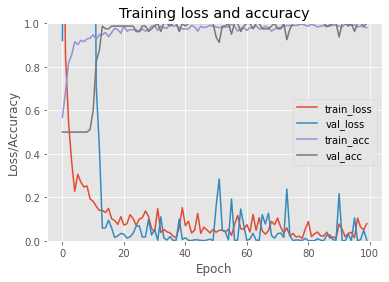

In [9]:
# make predictions on the testing set
print("Evaluating network.")
predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_))

# compute the confusion matrix and accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.ylim(0, 1)
plt.title("Training loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(figpath)

# serialize the model to disk
print("Saving COVID-19 detector model.")
model.save(modelpath, save_format="h5")